# Experiment # 1.
**Basic Node Classification with PCA**:
- Start with a simple GNN model, like a Graph Convolutional Network (GCN)
- Apply Principal Component Analysis (PCA) before feeding the data into the GNN
- Compare the classification performance on a small dataset like Zachary's Karate Club to see how DR impacts learning efficiency and accuracy.

Import section

In [17]:
import torch
from torch_geometric.datasets import Planetoid
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import numpy as np
from time import time
from tqdm import tqdm
from utils import *

random.seed(0)
torch.manual_seed(0)

print("Cuda available?", torch.cuda.is_available())

Cuda available? True


Use GPU if available.

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Load Cora dataset and check how many features are available:

In [19]:
dataset = Planetoid(root=".", name="Cora")
data = dataset[0]  # Graph data
num_features = data.x.shape[1]
print(f"Number of features before PCA: {num_features}")

Number of features before PCA: 1433


Perform PCA:

In [4]:
data = dataset[0]  # Graph data

# Standardizing the features
X = data.x.numpy()
X_std = StandardScaler().fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_std)

Scree plot

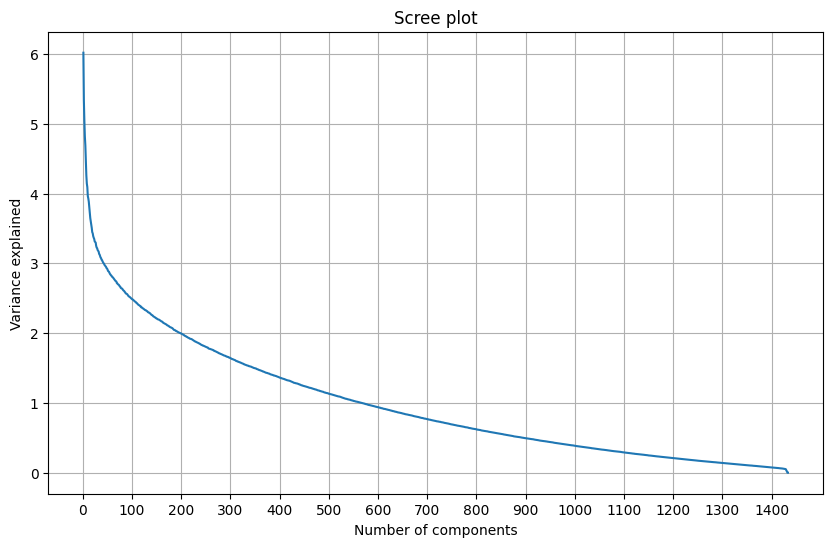

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_)
plt.title('Scree plot')
plt.xlabel('Number of components')
plt.ylabel('Variance explained')
plt.xticks(np.arange(0, len(pca.explained_variance_), step=100))
plt.grid(True)
plt.show()

We can see the "elbow" on n_components = 100, so this number of components will be chosen for further use.

In [20]:
n_components = 100

## 1. Cora classification without PCA

In order to inspect the influence of PCA dimensionality reduction, first the training without PCA will be performed.

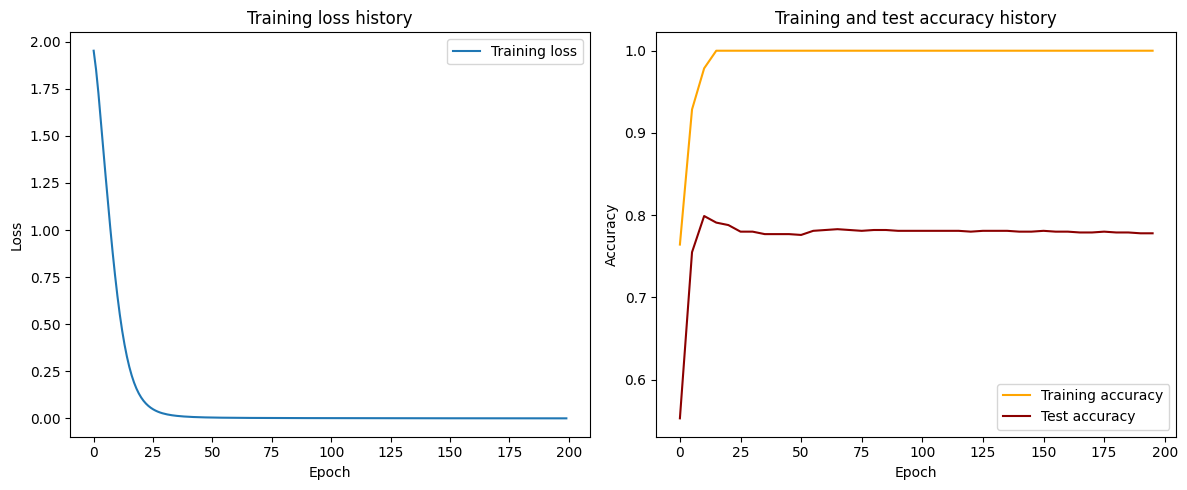

Train accuracy: 1.0000
Test accuracy: 0.7780


In [7]:
data = dataset[0].to(device)

# Model initialization
input_dim = dataset.num_node_features
hidden_dim = 16
output_dim = dataset.num_classes

model = GCN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
n_epochs = 200
loss_history, train_acc_history, test_acc_history = train_loop(n_epochs, model, optimizer, data)

plot_training_history(loss_history, train_acc_history, test_acc_history)
   
train_acc, test_acc = test(model, data)
print(f'Train accuracy: {train_acc:.4f}')
print(f'Test accuracy: {test_acc:.4f}')

Training is quite stable and the model gains it's target accuracy after around 20 epochs.

### Measuring the training time without PCA:

In [23]:
data = dataset[0].to(device)
run_training_times = []
for run in tqdm(range(100)):  # Train the model 5 times
    model = GCN(input_dim=dataset.num_node_features, hidden_dim=16, output_dim=dataset.num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    # Measure training time
    start_time = time()
    train_loop(200, model, optimizer, data, acc_freq=-1)
    end_time = time()
    training_time = end_time - start_time
    run_training_times.append(training_time)
    
print(f'Training time without PCA: {np.mean(run_training_times):.3f}')

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [04:12<00:00,  2.52s/it]

Training time without PCA: 2.476


## 2. Cora classification with PCA

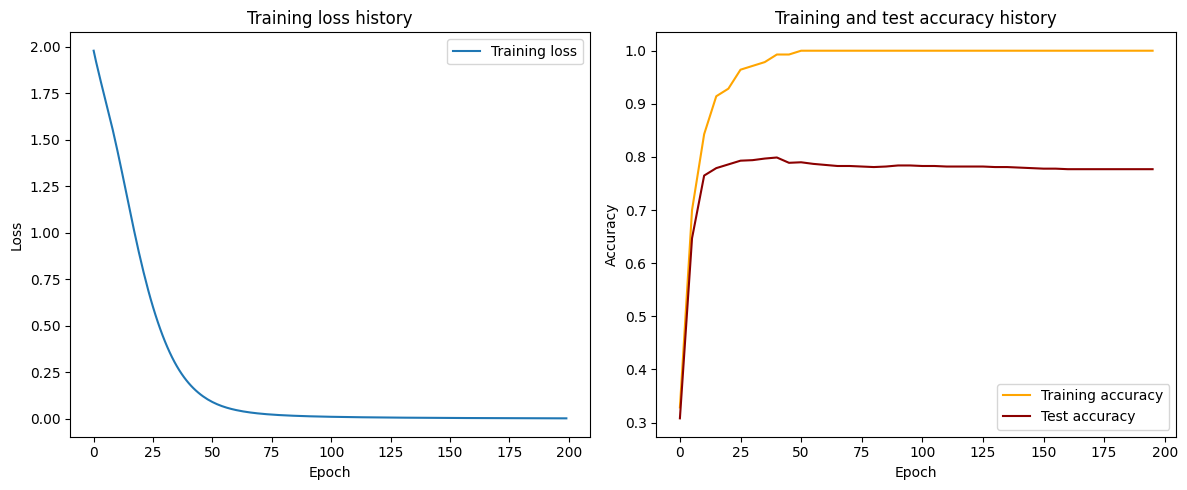

Train accuracy: 1.0000
Test accuracy: 0.7770


In [15]:
data = dataset[0]

# Fit PCA on training data only

pca = PCA(n_components=n_components)
train_features = data.x[data.train_mask].numpy()
pca.fit(train_features)

# Transform both training and testing features using the fitted PCA
data.x = torch.tensor(pca.transform(data.x.numpy()), dtype=torch.float)
data = data.to(device)


model = GCN(input_dim=pca.n_components_, hidden_dim=16, output_dim=dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

n_epochs = 200

loss_history, train_acc_history, test_acc_history = train_loop(n_epochs, model, optimizer, data)
plot_training_history(loss_history, train_acc_history, test_acc_history)
   
train_acc, test_acc = test(model, data)
print(f'Train accuracy: {train_acc:.4f}')
print(f'Test accuracy: {test_acc:.4f}')

The final accuracy is very similar, but it took more epochs for the model to reach it. Accuracies stabilized around epoch 50.

### Measuring the training time with PCA

In [22]:
data = dataset[0]

pca = PCA(n_components=n_components)
train_features = data.x[data.train_mask].numpy()
pca.fit(train_features)

# Transform both training and testing features using the fitted PCA
data.x = torch.tensor(pca.transform(data.x.numpy()), dtype=torch.float)
data = data.to(device)

run_training_times = []
for run in tqdm(range(100)):  # Train the model 5 times
    model = GCN(input_dim=pca.n_components_, hidden_dim=16, output_dim=dataset.num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    # Measure training time
    start_time = time()
    train_loop(200, model, optimizer, data, acc_freq=-1)
    end_time = time()
    training_time = end_time - start_time
    run_training_times.append(training_time)
    
print(f'Training time without PCA: {np.mean(run_training_times):.3f}')

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [03:53<00:00,  2.33s/it]

Training time without PCA: 2.314


### n_components ~ n_epochs ~ accuracy

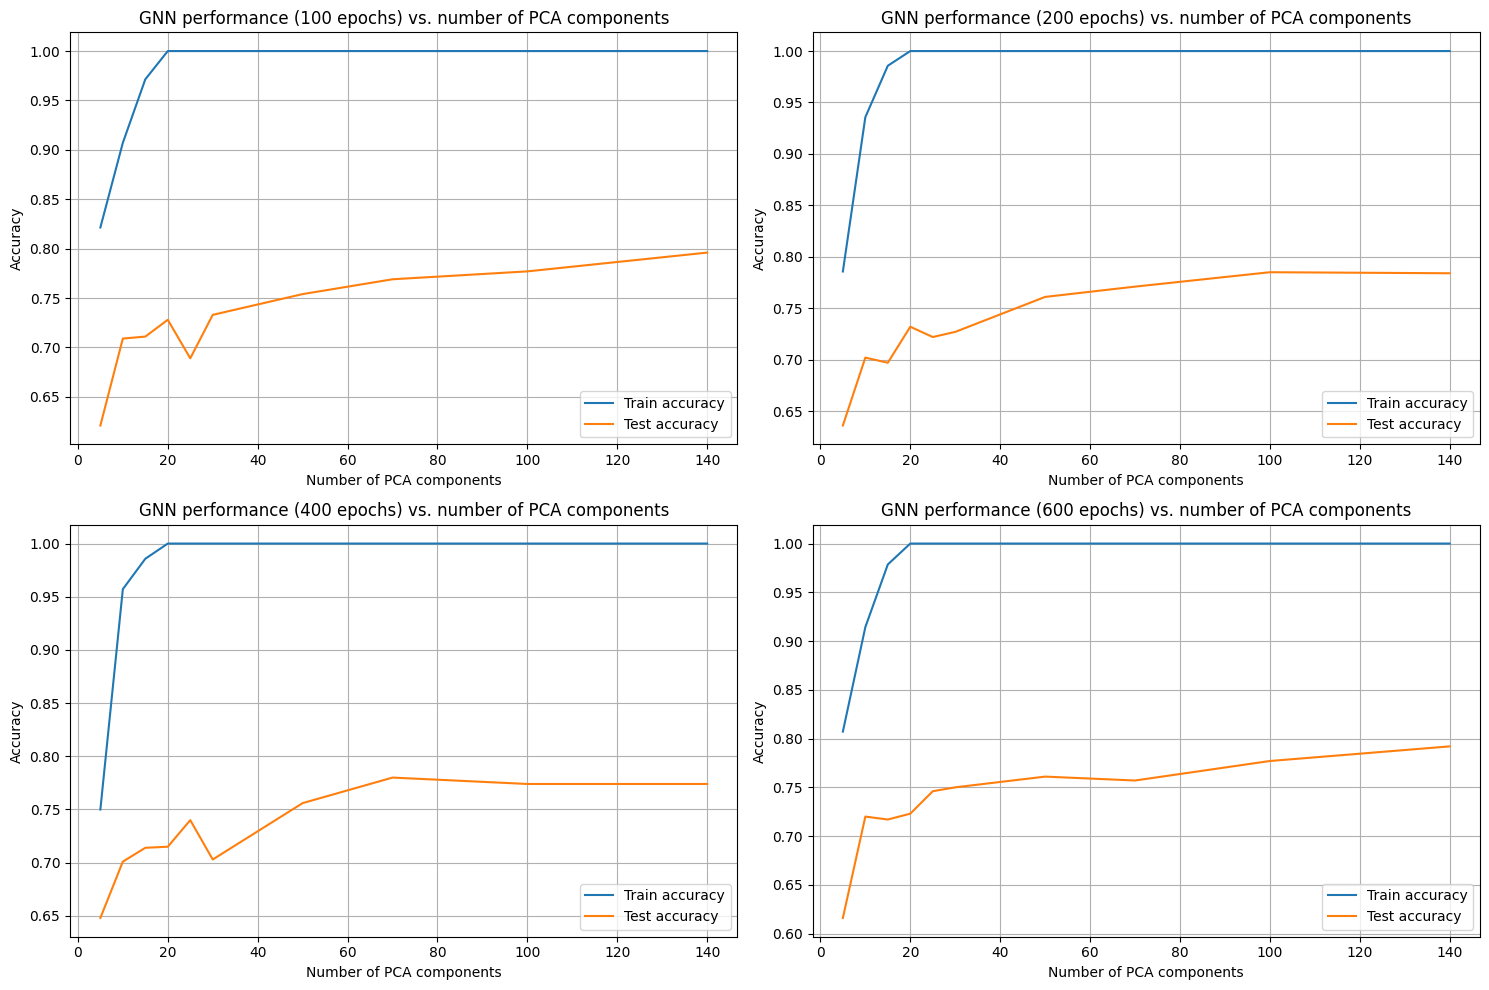

In [16]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

n_epochs_list = [100, 200, 400, 600]
n_components_list = [5, 10, 15, 20, 25, 30, 50, 70, 100, 140]

# Prepare the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # Adjust size as needed
axs = axs.flatten()  # Flatten the 2D array of axes for easier access

for i, n_epochs in enumerate(n_epochs_list):
    train_accuracies = []
    test_accuracies = []
    
    for n_components in n_components_list:
        data = dataset[0]
        
        # Fit PCA on training data only
        pca = PCA(n_components=n_components)
        train_features = data.x[data.train_mask].numpy()
        pca.fit(train_features)
        
        # Transform both training and testing features using the fitted PCA
        data.x = torch.tensor(pca.transform(data.x.numpy()), dtype=torch.float)
        data = data.to(device)
        
        model = GCN(input_dim=n_components, hidden_dim=16, output_dim=dataset.num_classes).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        
        train_loop(n_epochs, model, optimizer, data, acc_freq=-1)

        train_acc, test_acc = test(model, data)
        
        # Store the final accuracies
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        
    ax = axs[i]
    ax.plot(n_components_list, train_accuracies, label='Train accuracy')
    ax.plot(n_components_list, test_accuracies, label='Test accuracy')
    ax.set_xlabel('Number of PCA components')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'GNN performance ({n_epochs} epochs) vs. number of PCA components')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

In my opinion increasing the number of epochs doesn't have meaningful impact on accuracy vs number of PCA components.  
In this case, further tests will be performed on **n_epochs=200**.

100%|███████████████████████████████████████████████████████████████████████████████████| 28/28 [11:15<00:00, 24.12s/it]


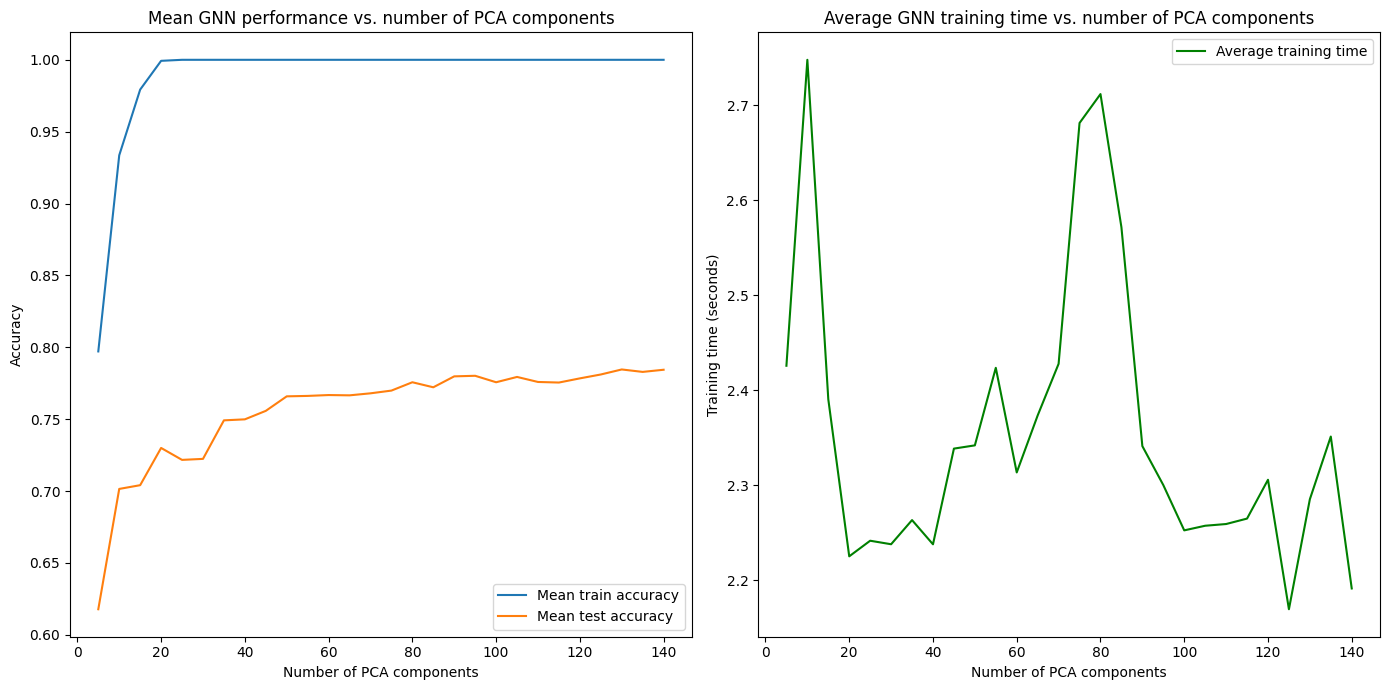

In [11]:
n_components_list = list(range(5, 145, 5))
average_train_accuracies = []
average_test_accuracies = []
average_training_times = []

for n_components in tqdm(n_components_list):
    data = dataset[0]
    
    # Fit PCA on training data only
    pca = PCA(n_components=n_components)
    train_features = data.x[data.train_mask].numpy()
    pca.fit(train_features)
    
    # Transform both training and testing features using the fitted PCA
    data.x = torch.tensor(pca.transform(data.x.numpy()), dtype=torch.float)
    data = data.to(device)
    
    # Initialize lists to store results for multiple runs
    run_training_times = []
    run_train_accuracies = []
    run_test_accuracies = []
    
    for run in range(10):  # Train the model 10 times
        model = GCN(input_dim=n_components, hidden_dim=16, output_dim=dataset.num_classes).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        
        # Training loop
        start_time = time()
        train_loop(200, model, optimizer, data, acc_freq=-1)
        end_time = time()
        training_time = end_time - start_time

        train_acc, test_acc = test(model, data)
        
        # Store results for this run
        run_training_times.append(training_time)
        run_train_accuracies.append(train_acc)
        run_test_accuracies.append(test_acc)
        
    # Calculate the mean of training times, train accuracies, and test accuracies over the 10 runs
    # Store the mean results
    average_training_times.append(np.mean(run_training_times))
    average_train_accuracies.append(np.mean(run_train_accuracies))
    average_test_accuracies.append(np.mean(run_test_accuracies))
    
# Plotting the results
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# Plot for mean accuracies
axs[0].plot(n_components_list, average_train_accuracies, label='Mean train accuracy')
axs[0].plot(n_components_list, average_test_accuracies, label='Mean test accuracy')
axs[0].set_xlabel('Number of PCA components')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Mean GNN performance vs. number of PCA components')
axs[0].legend()

# Plot for average training times
axs[1].plot(n_components_list, average_training_times, label='Average training time', color='green')
axs[1].set_xlabel('Number of PCA components')
axs[1].set_ylabel('Training time (seconds)')
axs[1].set_title('Average GNN training time vs. number of PCA components')
axs[1].legend()

plt.tight_layout()
plt.show()

Training time does not seem to have a correlation with the number of components used for PCA. Training the model even using the full set of features takes similar amount of time as training it on the reduced dataset. The cause of this behavior is probably relatively small trainin set, containing only 140 samples.

Measure PCA fit & transform time:

In [14]:
data = dataset[0]
pca_times = []
for _ in range(20):
    start_time = time()
    pca = PCA(n_components=100)
    train_features = data.x[data.train_mask].numpy()
    pca.fit(train_features)
    pca.transform(data.x.numpy())
    end_time = time()

    pca_times.append(end_time - start_time)

print(f"Mean PCA fit & transform time: {np.mean(pca_times):.3f}")

Mean PCA fit & transform time: 0.202


## Conclusions

- PCA does not seem to have any meaningful impact on GNN behavior.
- Both with and without PCA, the accuracy is almost the same.
- Training time is also not impacted by PCA.
- PCA does not have impact on verfitting. The only detail is that it takes longer for GNN to reach to the target accuracy.
- PCA could have better potential on data with significantly more training examples.